# Setting Up Environment

To reproduce our results,

1. Download our files [here](https://drive.google.com/drive/folders/1f1HjxLVVqhD47UwFa6Y6o9gIjSG26-3G?usp=sharing).
2. Create a vm instance from Google Cloud (we used Deployment Manager).
3. Download the `whoiswho-top-solutions` folder.
4. Create a bucket on Google cloud and upload the `whoiswho-top-solutions` folder to the bucket.
5. After you've done that, you can run the code in this Google Colab.

In [ ]:
# Connect to vm for no error
from google.cloud import storage
import os

In [ ]:
# Installing requirements for GCN baseline

!pip install numpy==1.24.4 scikit_learn==1.2.0 torch_geometric==2.5.2
!pip install tqdm==4.66.1 transformers==4.39.1 Unidecode==1.3.8

In [ ]:
# 3 minutes to run

# Create a storage client
storage_client = storage.Client()

# Get the bucket
# '145_bucket_cs'
# '145_bucket'
bucket = storage_client.get_bucket('145_bucket') # Make sure to change according to the bucket's name for your project

# List all the blobs (files) in the bucket
blobs = bucket.list_blobs()

# Download each blob to the VM
for blob in blobs:
    # Skip if blob is a directory (i.e., ends with '/')
    if blob.name.endswith('/'):
        continue

    # Create a directory for the blob if it doesn't exist
    directory = os.path.dirname(blob.name)
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Download the blob
    blob.download_to_filename(blob.name)

In [ ]:
import os
import subprocess

# Change the current working directory to the directory where you downloaded the files
os.chdir('/content/whoiswho-top-solutions/incorrect_assignment_detection/GCN')

!ls

In [ ]:
'''
Switch to GPU to run the baseline.
Runtime > Connect to a custom GCE VM

Project: cs145-423302
Zone: northamerica-northeast1-c or asia-east1-c
Instance: colab-1-vm or colab-2-vm

Provides information about the GPU that's currently used.
GPU ID is 0
'''

# Check GPU info
# If there is a connected GPU the output will be a table
!nvidia-smi

Fri Jun 14 00:18:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Set GPU
%env CUDA_VISIBLE_DEVICES=0 # 0 comes from our GPU ID above

env: CUDA_VISIBLE_DEVICES=0 # 0 comes from our GPU ID above


In [ ]:
import tensorflow as tf

def is_gpu_being_used():
    return tf.test.gpu_device_name() != ''

print(is_gpu_being_used())

True


In [ ]:
import random

# Sets random seed for reproducibility
SEED = 42
random.seed(SEED)

# Visualization

## Explorative Data Analysis

In [ ]:
import os
import subprocess

# Change the current working directory to the directory where you downloaded the files
os.chdir('/content/whoiswho-top-solutions/incorrect_assignment_detection/dataset')

!ls

In [ ]:
import json

# Load the dataset
with open('train_author.json', 'r') as f:
    train_author = json.load(f)

with open('ind_valid_author.json', 'r') as f:
    ind_valid_author = json.load(f)

with open('ind_valid_author_submit.json', 'r') as f:
    ind_valid_author_submit = json.load(f)

with open('pid_to_info_all.json', 'r') as f:
    pid_to_info_all = json.load(f)

# Initialize counters
num_authors = 0
num_papers = 0
author_papers = {}

# Count authors and papers from train_author.json
for author_id, author_info in train_author.items():
    num_authors += 1
    author_papers[author_id] = set(author_info['normal_data'] + author_info['outliers'])

# Count authors and papers from ind_valid_author.json
for author_id, author_info in ind_valid_author.items():
    num_authors += 1
    author_papers[author_id] = set(author_info['papers'])

# Count authors and papers from ind_valid_author_submit.json
for author_id, paper_scores in ind_valid_author_submit.items():
    if author_id not in author_papers:
        num_authors += 1
        author_papers[author_id] = set(paper_scores.keys())

# Count papers from pid_to_info_all.json
for paper_id in pid_to_info_all:
    num_papers += 1

# Calculate the total number of unique papers across all authors
all_papers = set()
for author_papers_set in author_papers.values():
    all_papers.update(author_papers_set)
num_unique_papers = len(all_papers)

# Print the overall statistics
print(f"Number of authors: {num_authors}")
print(f"Number of papers: {num_papers}")
print(f"Number of unique papers: {num_unique_papers}")

Number of authors: 1149
Number of papers: 317302
Number of unique papers: 204378


In [ ]:
import json

# Load the dataset
with open('train_author.json', 'r') as f:
    train_author = json.load(f)

# Initialize counter
author_stats = []

# Iterate over the authors and count the papers
for author_id, author_info in train_author.items():
    author_stats.append({
        'author_id': author_id,
        'author_name': author_info['name'],
        'num_normal_papers': len(author_info['normal_data']),
        'num_outlier_papers': len(author_info['outliers'])
    })

# Print the statistics for each author
print("\nAuthor-level statistics:")
for stat in author_stats:
    print(f"Author ID: {stat['author_id']}, Name: {stat['author_name']}, Normal Papers: {stat['num_normal_papers']}, Outlier Papers: {stat['num_outlier_papers']}")


Author-level statistics:
Author ID: Iki037dt, Name: atsushi ochiai, Normal Papers: 550, Outlier Papers: 15
Author ID: ZihzMro7, Name: mingwu yang, Normal Papers: 34, Outlier Papers: 6
Author ID: WXMYBk3c, Name: jianzhao huang, Normal Papers: 41, Outlier Papers: 33
Author ID: WrCODHhe, Name: xuebiao yao, Normal Papers: 14, Outlier Papers: 39
Author ID: k3uSCGEE, Name: shunlin tang, Normal Papers: 23, Outlier Papers: 13
Author ID: jSYjqjLk, Name: guang yang, Normal Papers: 6, Outlier Papers: 28
Author ID: 58EMV3we, Name: xuxiang zhang, Normal Papers: 143, Outlier Papers: 6
Author ID: EtC3aryF, Name: li chen, Normal Papers: 137, Outlier Papers: 8
Author ID: Ca1oUIWu, Name: tao liu, Normal Papers: 10, Outlier Papers: 26
Author ID: duZ3G6zi, Name: rong yu, Normal Papers: 150, Outlier Papers: 22
Author ID: gqb6K8Ep, Name: peter burger, Normal Papers: 422, Outlier Papers: 19
Author ID: Fng2IIma, Name: xiaoqing zeng, Normal Papers: 261, Outlier Papers: 5
Author ID: cGP81Ewi, Name: xiuling xu,

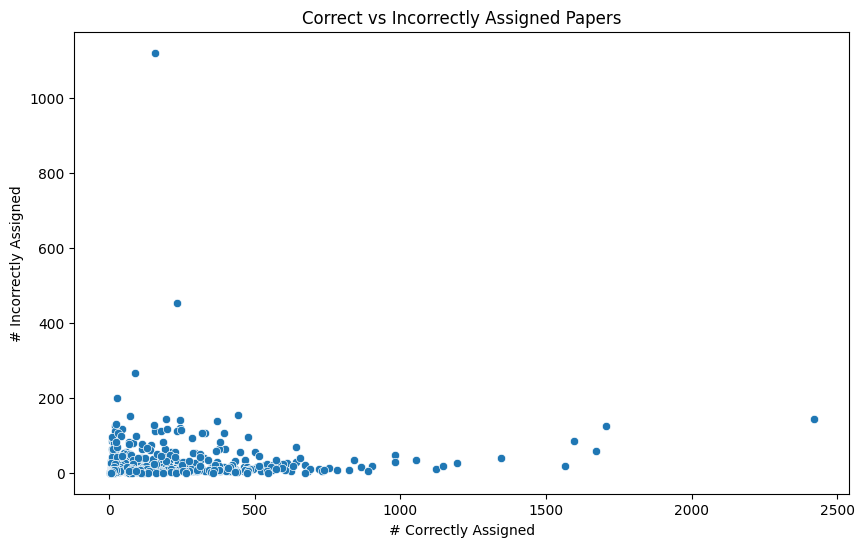

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the dataset
with open('train_author.json', 'r') as f:
    train_author = json.load(f)

# Convert data to pandas DataFrame
author_data = []
for author_id, author_info in train_author.items():
    num_normal_papers = len(author_info['normal_data'])
    num_outlier_papers = len(author_info['outliers'])
    author_data.append({
        'author_id': author_id,
        'author_name': author_info['name'],
        'num_normal_papers': num_normal_papers,
        'num_outlier_papers': num_outlier_papers
    })

author_df = pd.DataFrame(author_data)

# Plot scatter plot of normal vs. outlier papers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=author_df, x='num_normal_papers', y='num_outlier_papers')
plt.title('Correct vs Incorrectly Assigned Papers')
plt.xlabel('# Correctly Assigned')
plt.ylabel('# Incorrectly Assigned')
plt.show()

The following graph shows us that there is no correlation between the number of normal (correctly assigned papers) to the number of outliers (incorrectly assigned paper) for each author.

From the graph it seems that most authors, despite how many correctly assigned papers they have, mostly have incorrectly assigned papers that are less than 200.

In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud

# Load the dataset
with open('train_author.json', 'r') as f:
    train_author = json.load(f)

with open('pid_to_info_all.json', 'r') as f:
    pid_to_info_all = json.load(f)

# Convert data to pandas DataFrame for easier manipulation
author_data = []
for author_id, author_info in train_author.items():
    num_normal_papers = len(author_info['normal_data'])
    num_outlier_papers = len(author_info['outliers'])
    author_data.append({
        'author_id': author_id,
        'author_name': author_info['name'],
        'num_normal_papers': num_normal_papers,
        'num_outlier_papers': num_outlier_papers
    })

author_df = pd.DataFrame(author_data)

In [ ]:
author_df.head()

,author_id,author_name,num_normal_papers,num_outlier_papers
0,Iki037dt,atsushi ochiai,550,15
1,ZihzMro7,mingwu yang,34,6
2,WXMYBk3c,jianzhao huang,41,33
3,WrCODHhe,xuebiao yao,14,39
4,k3uSCGEE,shunlin tang,23,13


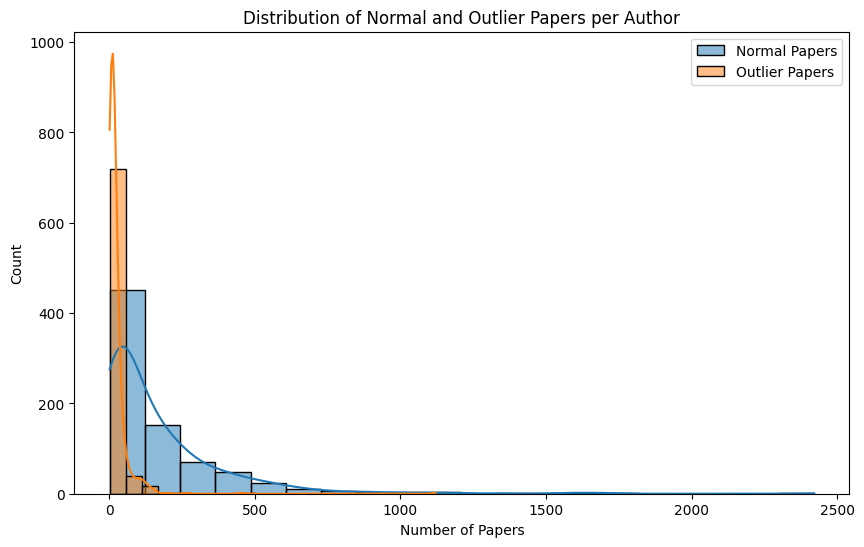

In [ ]:
# Plot distribution of normal and outlier papers per author
plt.figure(figsize=(10, 6))
sns.histplot(data=author_df, x='num_normal_papers', bins=20, kde=True, label='Normal Papers')
sns.histplot(data=author_df, x='num_outlier_papers', bins=20, kde=True, label='Outlier Papers')
plt.title('Distribution of Normal and Outlier Papers per Author')
plt.xlabel('Number of Papers')
plt.ylabel('Count')
plt.legend()
plt.show()

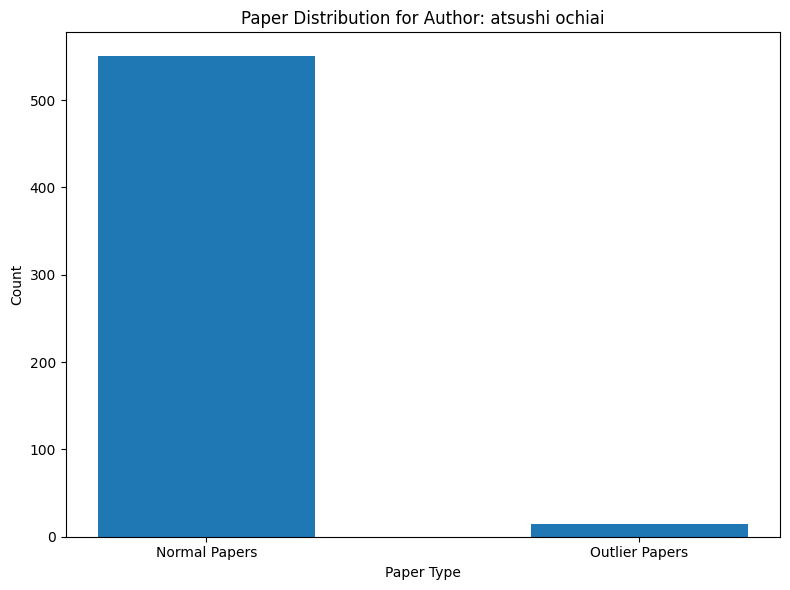

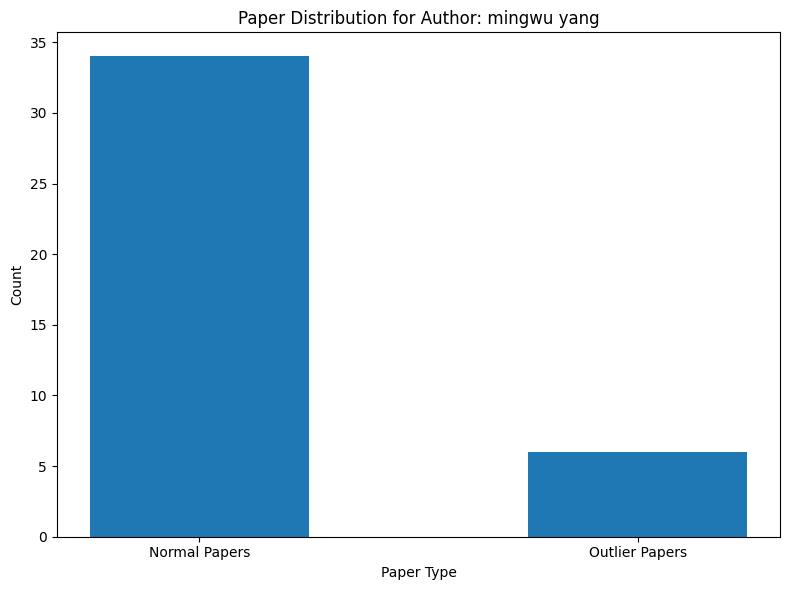

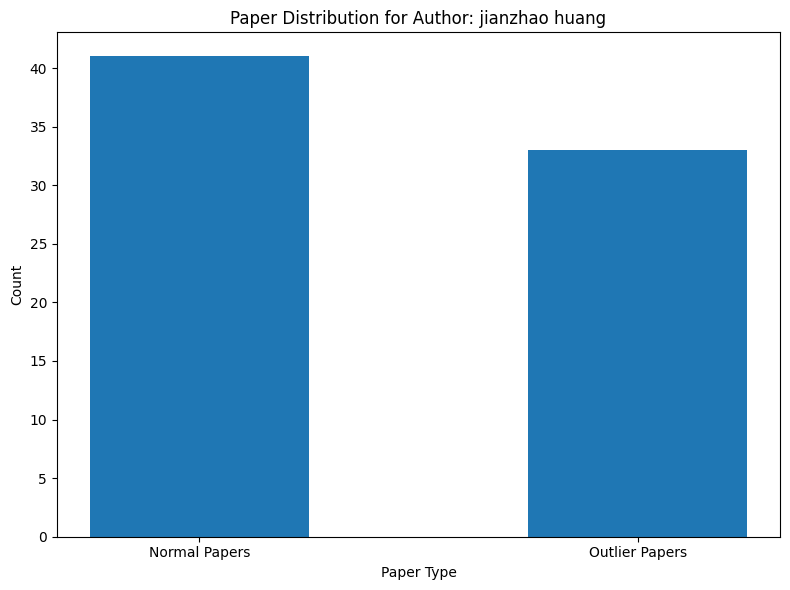

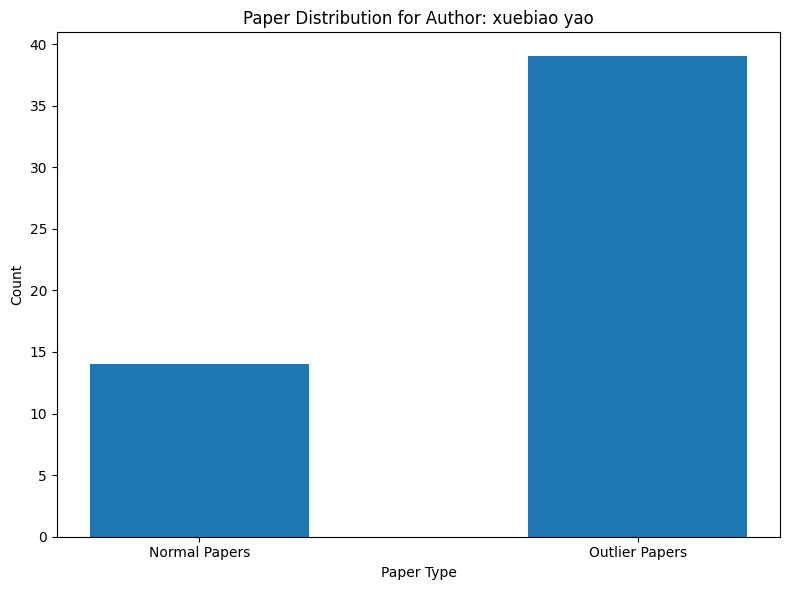

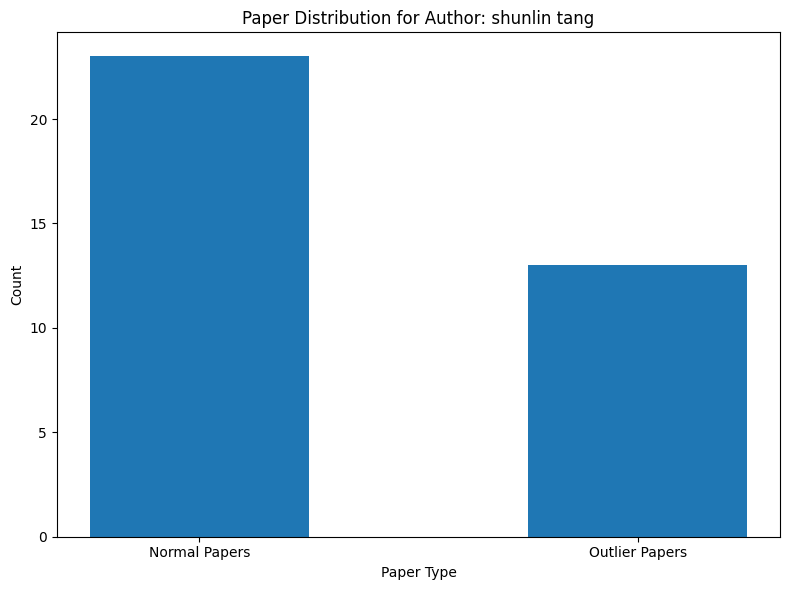

In [ ]:
import json
import matplotlib.pyplot as plt

# Load the dataset
with open('train_author.json', 'r') as f:
    train_author = json.load(f)

# Create a bar chart for each author
counter = 0
for author_id, author_info in train_author.items():
    # If we've already plotted 5 authors, break the loop
    if counter >= 5:
        break

    name = author_info['name']
    normal_data_count = len(author_info['normal_data'])
    outliers_count = len(author_info['outliers'])

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Set up the bar chart
    bar_width = 0.5
    x_positions = [0, 1]
    bar_labels = ['Normal Papers', 'Outlier Papers']
    bar_counts = [normal_data_count, outliers_count]

    # Plot the bars
    ax.bar(x_positions, bar_counts, bar_width, align='center')

    # Add labels and title
    ax.set_xticks(x_positions)
    ax.set_xticklabels(bar_labels)
    ax.set_xlabel('Paper Type')
    ax.set_ylabel('Count')
    ax.set_title(f'Paper Distribution for Author: {name}')

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Increment the counter
    counter += 1


In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Load the datasets
with open('train_author.json', 'r') as f:
    train_author = json.load(f)

with open('pid_to_info_all.json', 'r') as f:
    pid_to_info = json.load(f)

# Create a DataFrame from the dataset
data = []
for author_id, author_info in train_author.items():
    normal_papers = author_info['normal_data']
    outlier_papers = author_info['outliers']
    for paper_id in normal_papers + outlier_papers:
        paper_info = pid_to_info[paper_id]
        paper_info['author'] = author_id
        paper_info['is_outlier'] = paper_id in outlier_papers
        data.append(paper_info)

data = pd.DataFrame(data)

In [ ]:
data.head()

,id,title,abstract,keywords,authors,venue,year,author,is_outlier
0,YzOCpPTO,THE POWER OF THE HIGH-SENSITIVE KRAS TEST TO P...,,,"[{'name': 'Hideaki Bando', 'org': ''}, {'name'...",ANNALS OF ONCOLOGY,2010,Iki037dt,False
1,AblgcGjH,1812 NICARDIPINE VERSUS SALINE INJECTION AS TR...,,[],"[{'name': 'jintetsu soh', 'org': ''}, {'name':...",The Journal of Urology,2011,Iki037dt,False
2,B5aouLse,Possible use of ultrasound estimated bladder w...,The present study was designed to reveal the p...,"[vesicoureteral reflux, bladder hypertrophy, c...","[{'name': 'M Inaba', 'org': 'Department of Uro...",Ultrasound in medicine & biology,2001,Iki037dt,False
3,u1G7wBEv,Interaction between epidermal growth factor an...,,[],"[{'name': 'hisao ito', 'org': ''}, {'name': 'm...",Journal of Steroid Biochemistry,1987,Iki037dt,False
4,W7w6P8lA,Comprehensive Analyses Using Next-Generation S...,"In advanced gastric cancer (AGC), most clinica...","[gastric cancer, amplification, mutation, next...","[{'name': 'yasutoshi kuboki', 'org': 'Departme...",Annals of Oncology,2015,Iki037dt,False


# Running GCN Baseline for KDD Cup 2024

We skipped running the the first three code cells where we use encoding.py and build_graph.py since our TA has already ran those code for us and uploaded the outputted files at this [link](https://ucla.app.box.com/s/52ysfbfldz6wuhb1f1ad13syec7dxpxe).

After downloading the files from the link we ran the last code cell where we run train.py.

## Getting Started

In [ ]:
import os
import subprocess

# Change the current working directory to the directory where you downloaded the files
os.chdir('/content/whoiswho-top-solutions/incorrect_assignment_detection/GCN')

!ls

benji_modified_models.py  encoding.py  modified_models.py  README.md	     train.py
benji_modified_train.py   log	       modified_train.py   requirements.txt  utils.py
build_graph.py		  models.py    __pycache__	   saved_model


## Baseline

### Code (Skip)

In [ ]:
# Preprocess the data
# Generate RoBERTa embeddings for paper titles
!python encoding.py --path ../dataset/pid_to_info_all.json --save_path ../dataset/roberta_embeddings.pkl

In [ ]:
# Preprocess the data
# Build graph representation and save dataset for training
!python build_graph.py --author_dir ../dataset/train_author.json --pub_dir ../dataset/pid_to_info_all.json --save_dir ../dataset/train.pkl --embeddings_dir ../dataset/roberta_embeddings_train.pkl

In [ ]:
# Preprocess the data
# Build graph representation and save dataset for validation/testing
!python build_graph.py --author_dir ../dataset/ind_valid_author.json --pub_dir ../dataset/pid_to_info_all.json --save_dir ../dataset/valid.pkl --embeddings_dir ../dataset/roberta_embeddings_test.pkl

### Code (Run)

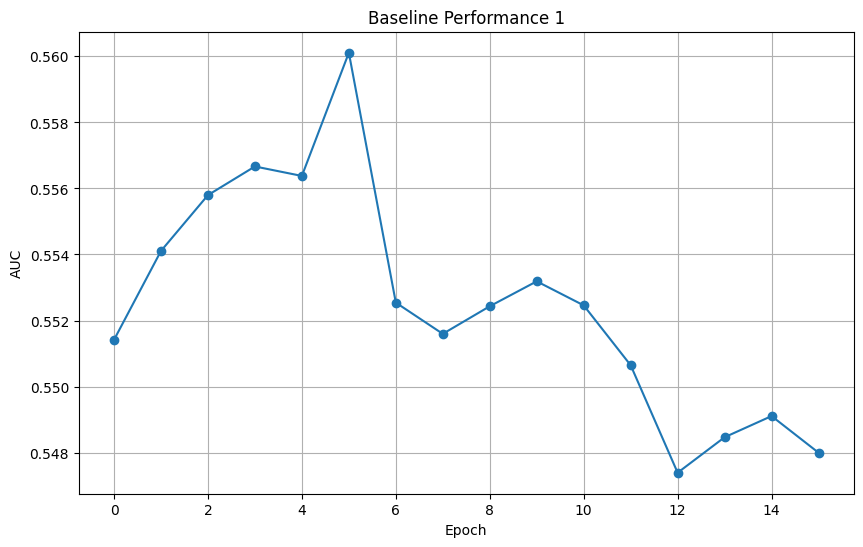

Maximum AUC value: 0.560111 (Epoch: 5)


In [ ]:
import re
import matplotlib.pyplot as plt

# Capture the output of train.py
output = !python train.py --train_dir ../dataset/train.pkl --test_dir ../dataset/valid.pkl --epochs 50 --bs 32 --lr 0.001

# Extract the AUC values from the output
auc_values = []
max_auc1 = 0
max_epoch1 = 0
for line in output:
    match = re.search(r'Epoch: (\d+) Auc: (\d+\.\d+)', line)
    if match:
        epoch = int(match.group(1))
        auc = float(match.group(2))
        auc_values.append((epoch, auc))
        if auc > max_auc1:
            max_auc1 = auc
            max_epoch1 = epoch

# Sort the AUC values by epoch
auc_values.sort(key=lambda x: x[0])

# Extract the epoch numbers and AUC values separately
epochs, aucs = zip(*auc_values)

# Plot the AUC values
plt.figure(figsize=(10, 6))
plt.plot(epochs, aucs, marker='o')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Baseline Performance 1')
plt.grid(True)
# plt.savefig('auc_plot.png')
plt.show()

# Print the maximum AUC value and the corresponding epoch
print(f"Maximum AUC value: {max_auc1:.6f} (Epoch: {max_epoch1})")

From the `Baseline Performance 1` graph we see that after the 5th epoch the AUC drops drastically and continues to drop. This may indicate that we are overfitting and that our model cannot generalize well to unseen data.

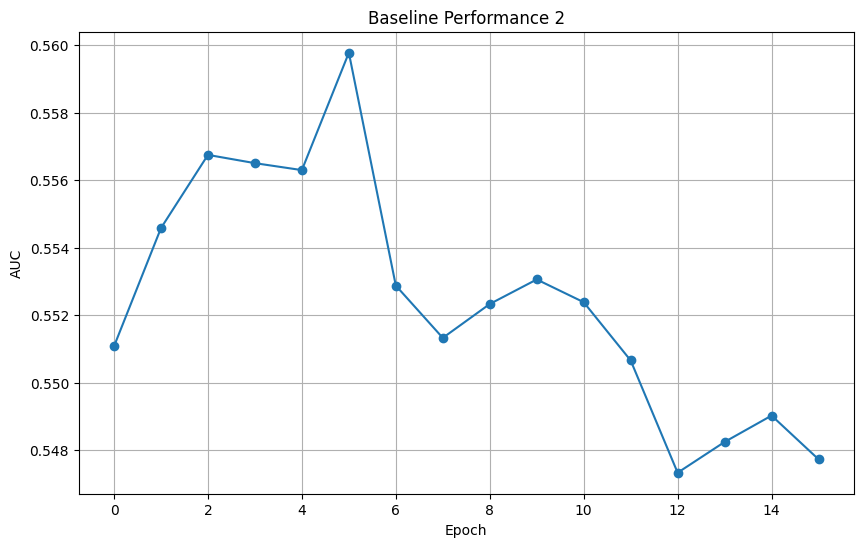

Maximum AUC value: 0.559777 (Epoch: 5)


In [ ]:
# Connect to GPU or else will run into error

import re
import matplotlib.pyplot as plt

# Capture the output of train.py
output = !python train.py --train_dir ../dataset/train.pkl --test_dir ../dataset/valid.pkl --epochs 50 --bs 32 --lr 0.001

# Extract the AUC values from the output
auc_values = []
max_auc2 = 0
max_epoch2 = 0
for line in output:
    match = re.search(r'Epoch: (\d+) Auc: (\d+\.\d+)', line)
    if match:
        epoch = int(match.group(1))
        auc = float(match.group(2))
        auc_values.append((epoch, auc))
        if auc > max_auc2:
            max_auc2 = auc
            max_epoch2 = epoch

# Sort the AUC values by epoch
auc_values.sort(key=lambda x: x[0])

# Extract the epoch numbers and AUC values separately
epochs, aucs = zip(*auc_values)

# Plot the AUC values
plt.figure(figsize=(10, 6))
plt.plot(epochs, aucs, marker='o')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Baseline Performance 2')
plt.grid(True)
plt.show()

# Print the maximum AUC value and the corresponding epoch
print(f"Maximum AUC value: {max_auc2:.6f} (Epoch: {max_epoch2})")

Similarly, we see the same behavior for the `Baseline Performance 2` graph. After the 5th epoch the AUC continues to drop.

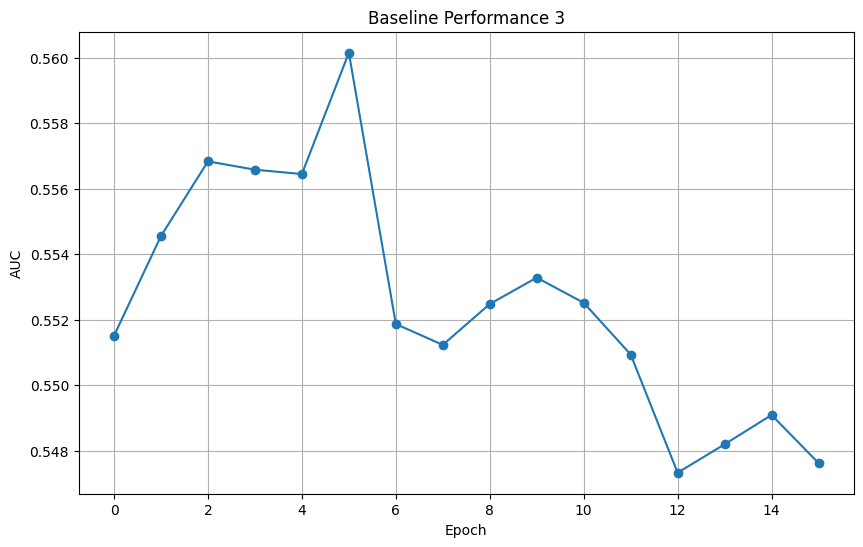

Maximum AUC value: 0.560156 (Epoch: 5)


In [ ]:
# Connect to GPU or else will run into error

import re
import matplotlib.pyplot as plt

# Capture the output of train.py
output = !python train.py --train_dir ../dataset/train.pkl --test_dir ../dataset/valid.pkl --epochs 50 --bs 32 --lr 0.001

# Extract the AUC values from the output
auc_values = []
max_auc3 = 0
max_epoch3 = 0
for line in output:
    match = re.search(r'Epoch: (\d+) Auc: (\d+\.\d+)', line)
    if match:
        epoch = int(match.group(1))
        auc = float(match.group(2))
        auc_values.append((epoch, auc))
        if auc > max_auc3:
            max_auc3 = auc
            max_epoch3 = epoch

# Sort the AUC values by epoch
auc_values.sort(key=lambda x: x[0])

# Extract the epoch numbers and AUC values separately
epochs, aucs = zip(*auc_values)

# Plot the AUC values
plt.figure(figsize=(10, 6))
plt.plot(epochs, aucs, marker='o')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Baseline Performance 3')
plt.grid(True)
plt.show()

# Print the maximum AUC value and the corresponding epoch
print(f"Maximum AUC value: {max_auc3:.6f} (Epoch: {max_epoch3})")

Similarly, we see the same behavior for the `Baseline Performance 3` graph. We are now convinced that our model is overfitting. To combat this we will try to apply regularization.

In [ ]:
avg_max_auc = (max_auc1+max_auc2+max_auc3)/3

print(f"The average maximum AUC value is: {avg_max_auc:.6f}")

The average maximum AUC value is: 0.560015


Since we get a different maximum AUC value each time we train, we want to get a better measure of it by taking the average which turns out to be 0.560015.

# Method 1: Regularization

In our modified_train.py file we decided to apply L2 Regularization since we didn't want to zero any of the features.

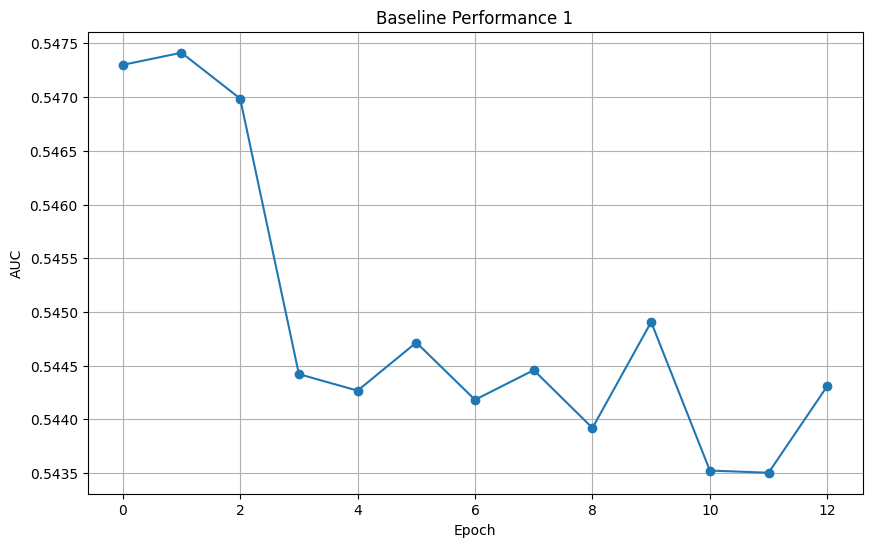

Maximum AUC value: 0.547413 (Epoch: 1)


In [ ]:
import re
import matplotlib.pyplot as plt

# Capture the output of train.py
output = !python modified_train.py --train_dir ../dataset/train.pkl --test_dir ../dataset/valid.pkl --epochs 50 --bs 32 --lr 0.001

# Extract the AUC values from the output
auc_values = []
max_auc1 = 0
max_epoch1 = 0
for line in output:
    match = re.search(r'Epoch: (\d+) Auc: (\d+\.\d+)', line)
    if match:
        epoch = int(match.group(1))
        auc = float(match.group(2))
        auc_values.append((epoch, auc))
        if auc > max_auc1:
            max_auc1 = auc
            max_epoch1 = epoch

# Sort the AUC values by epoch
auc_values.sort(key=lambda x: x[0])

# Extract the epoch numbers and AUC values separately
epochs, aucs = zip(*auc_values)

# Plot the AUC values
plt.figure(figsize=(10, 6))
plt.plot(epochs, aucs, marker='o')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Baseline Performance 1')
plt.grid(True)
# plt.savefig('auc_plot.png')
plt.show()

# Print the maximum AUC value and the corresponding epoch
print(f"Maximum AUC value: {max_auc1:.6f} (Epoch: {max_epoch1})")

From the `Baseline Performance 1` graph we see that after the 1st epoch the AUC value heavily decreased, making our model perform even worse after L2 regularization.

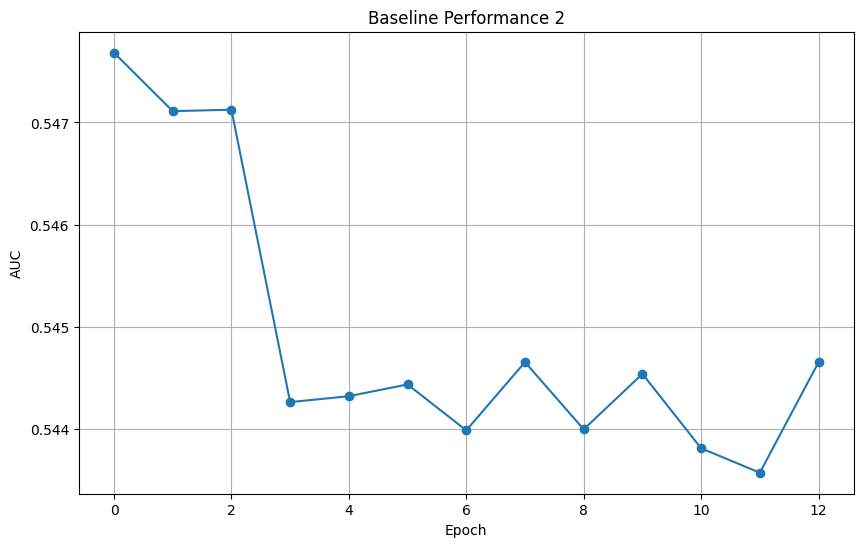

Maximum AUC value: 0.547681 (Epoch: 0)


In [ ]:
# Connect to GPU or else will run into error

import re
import matplotlib.pyplot as plt

# Capture the output of train.py
output = !python modified_train.py --train_dir ../dataset/train.pkl --test_dir ../dataset/valid.pkl --epochs 50 --bs 32 --lr 0.001

# Extract the AUC values from the output
auc_values = []
max_auc2 = 0
max_epoch2 = 0
for line in output:
    match = re.search(r'Epoch: (\d+) Auc: (\d+\.\d+)', line)
    if match:
        epoch = int(match.group(1))
        auc = float(match.group(2))
        auc_values.append((epoch, auc))
        if auc > max_auc2:
            max_auc2 = auc
            max_epoch2 = epoch

# Sort the AUC values by epoch
auc_values.sort(key=lambda x: x[0])

# Extract the epoch numbers and AUC values separately
epochs, aucs = zip(*auc_values)

# Plot the AUC values
plt.figure(figsize=(10, 6))
plt.plot(epochs, aucs, marker='o')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Baseline Performance 2')
plt.grid(True)
plt.show()

# Print the maximum AUC value and the corresponding epoch
print(f"Maximum AUC value: {max_auc2:.6f} (Epoch: {max_epoch2})")

Similarly from the `Baseline Performance 2` graph we see that after the 0th epoch the AUC value heavily decreased, making our model perform even worse after L2 regularization.

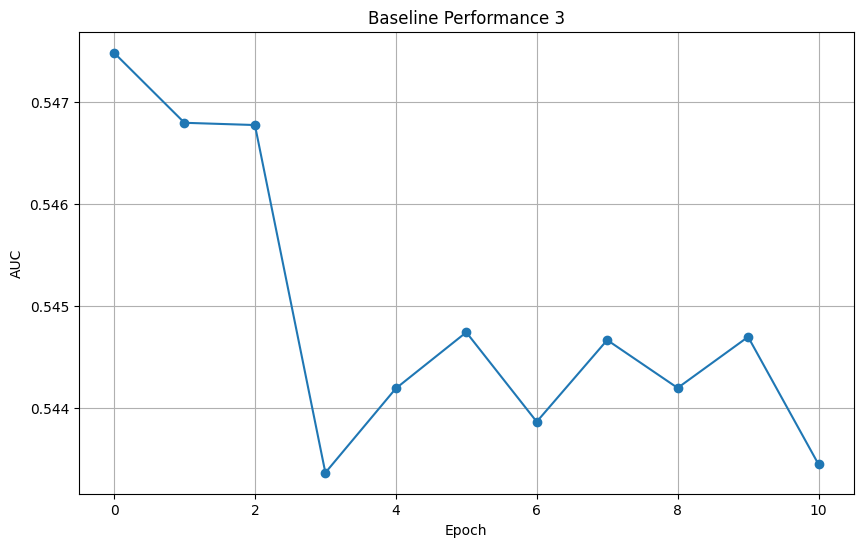

Maximum AUC value: 0.547480 (Epoch: 0)


In [ ]:
# Connect to GPU or else will run into error

import re
import matplotlib.pyplot as plt

# Capture the output of train.py
output = !python modified_train.py --train_dir ../dataset/train.pkl --test_dir ../dataset/valid.pkl --epochs 50 --bs 32 --lr 0.001

# Extract the AUC values from the output
auc_values = []
max_auc3 = 0
max_epoch3 = 0
for line in output:
    match = re.search(r'Epoch: (\d+) Auc: (\d+\.\d+)', line)
    if match:
        epoch = int(match.group(1))
        auc = float(match.group(2))
        auc_values.append((epoch, auc))
        if auc > max_auc3:
            max_auc3 = auc
            max_epoch3 = epoch

# Sort the AUC values by epoch
auc_values.sort(key=lambda x: x[0])

# Extract the epoch numbers and AUC values separately
epochs, aucs = zip(*auc_values)

# Plot the AUC values
plt.figure(figsize=(10, 6))
plt.plot(epochs, aucs, marker='o')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Baseline Performance 3')
plt.grid(True)
plt.show()

# Print the maximum AUC value and the corresponding epoch
print(f"Maximum AUC value: {max_auc3:.6f} (Epoch: {max_epoch3})")

This same trend continues for the `Baseline Performance 3` graph.

In [ ]:
avg_max_auc = (max_auc1+max_auc2+max_auc3)/3

print(f"The average maximum AUC value is: {avg_max_auc:.6f}")

The average maximum AUC value is: 0.547525


Comparing the average maximum AUC value before and after L2 Regularization:

**Before** average maximum AUC value is: 0.560015

**After** average maximum AUC value is: 0.547525

As expected from the graphs, our model performed worse.

Performing worse after applying L2 Regularization could potentially imply that our model may not be too complex so applying regularization on it makes it too simple which causes our model or underfit.

# Method 2: Add Complexity

In [ ]:
# Change the current working directory to the directory where you downloaded the files
os.chdir('/content/whoiswho-top-solutions/incorrect_assignment_detection/GCN')
!ls

Running our updated model with hyperparameters tuned:

In [ ]:
!python benji_modified_train.py --train_dir ../dataset/train.pkl --test_dir ../dataset/valid.pkl --epochs 50 --bs 16 --lr 0.003

[2024-06-14 07:42:03] {benji_modified_train.py:83} INFO - Namespace(train_dir='../dataset/train.pkl', eval_dir=None, test_dir='../dataset/valid.pkl', saved_dir='saved_model', log_name='log', epochs=50, seed=1, lr=0.003, min_lr=0.0002, bs=16, input_dim=768, output_dim=768, verbose=1, usecoo=False, usecov=False, threshold=0)
[2024-06-14 07:42:06] {benji_modified_train.py:100} INFO - # Batch: 545 - 34.0625
[2024-06-14 07:42:06] {benji_modified_train.py:105} INFO - max_step: 340, 545, 16, 50
100% 545/545 [00:06<00:00, 84.91it/s] 
[2024-06-14 07:42:12] {benji_modified_train.py:152} INFO - Epoch:0 Overall loss: 0.197743 
100% 234/234 [00:01<00:00, 158.67it/s]
[2024-06-14 07:42:14] {benji_modified_train.py:195} INFO - Epoch: 0 Auc: 0.444181 Maps: 0.633284 Max-Auc: -1.000000 Max-Maps: -1.000000
[2024-06-14 07:42:14] {benji_modified_train.py:205} INFO - ***************** Epoch: 0 Max Auc: 0.444181 Maps: 0.633284 *******************
100% 545/545 [00:04<00:00, 110.94it/s]
[2024-06-14 07:42:19] {b

Testing the model without batchnorm:

In [ ]:
!python benji_modified_train.py --train_dir ../dataset/train.pkl --test_dir ../dataset/valid.pkl --epochs 50 --bs 16 --lr 0.003

[2024-06-14 04:57:51] {benji_modified_train.py:83} INFO - Namespace(train_dir='../dataset/train.pkl', eval_dir=None, test_dir='../dataset/valid.pkl', saved_dir='saved_model', log_name='log', epochs=50, seed=1, lr=0.003, min_lr=0.0002, bs=16, input_dim=768, output_dim=768, verbose=1, usecoo=False, usecov=False, threshold=0)
[2024-06-14 04:57:54] {benji_modified_train.py:100} INFO - # Batch: 545 - 34.0625
[2024-06-14 04:57:54] {benji_modified_train.py:105} INFO - max_step: 340, 545, 16, 50
100% 545/545 [00:06<00:00, 87.64it/s] 
[2024-06-14 04:58:00] {benji_modified_train.py:152} INFO - Epoch:0 Overall loss: 0.181826 
100% 234/234 [00:01<00:00, 161.06it/s]
[2024-06-14 04:58:02] {benji_modified_train.py:195} INFO - Epoch: 0 Auc: 0.551868 Maps: 0.686964 Max-Auc: -1.000000 Max-Maps: -1.000000
[2024-06-14 04:58:02] {benji_modified_train.py:205} INFO - ***************** Epoch: 0 Max Auc: 0.551868 Maps: 0.686964 *******************
100% 545/545 [00:04<00:00, 118.92it/s]
[2024-06-14 04:58:07] {b

Testing the model with batchnorm:

In [ ]:
!python train.py --train_dir ../dataset/train.pkl --test_dir ../dataset/valid.pkl --epochs 11 --bs 16 --lr 0.003

[2024-06-14 05:05:35] {train.py:83} INFO - Namespace(train_dir='../dataset/train.pkl', eval_dir=None, test_dir='../dataset/valid.pkl', saved_dir='saved_model', log_name='log', epochs=11, seed=1, lr=0.003, min_lr=0.0002, bs=16, input_dim=768, output_dim=768, verbose=1, usecoo=False, usecov=False, threshold=0)
[2024-06-14 05:05:38] {train.py:100} INFO - # Batch: 545 - 34.0625
[2024-06-14 05:05:38] {train.py:105} INFO - max_step: 340, 545, 16, 11
100% 545/545 [00:04<00:00, 122.60it/s]
[2024-06-14 05:05:43] {train.py:152} INFO - Epoch:0 Overall loss: 0.178811 
100% 234/234 [00:01<00:00, 225.46it/s]
[2024-06-14 05:05:44] {train.py:195} INFO - Epoch: 0 Auc: 0.554161 Maps: 0.688684 Max-Auc: -1.000000 Max-Maps: -1.000000
[2024-06-14 05:05:44] {train.py:205} INFO - ***************** Epoch: 0 Max Auc: 0.554161 Maps: 0.688684 *******************
100% 545/545 [00:03<00:00, 179.12it/s]
[2024-06-14 05:05:47] {train.py:152} INFO - Epoch:1 Overall loss: 0.187728 
100% 234/234 [00:00<00:00, 265.65it/s]